In [1]:
!pip install -U scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
# ===============================================================
# ENHANCED LOGISTIC REGRESSION PIPELINE (70–75% Macro-F1 expected)
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

sns.set_theme()

# ======================
# LOAD PROCESSED DATA
# ======================
train = pd.read_csv("/kaggle/input/preprocess-travel/train_processed.csv")
test  = pd.read_csv("/kaggle/input/preprocess-travel/test_processed.csv")

TARGET = "spend_category"
IDCOL = "trip_id"

In [3]:
X = train.drop(columns=[TARGET, IDCOL])
y = train[TARGET]
X_test = test.drop(columns=[IDCOL])

# ======================
# TRAIN-VALIDATION SPLIT
# ======================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ======================
# SMOTE Oversampling (fix imbalance)
# ======================
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# ======================
# FEATURE SELECTION
# ======================
k = min(80, X.shape[1])  # Cap feature count for LR stability
selector = SelectKBest(f_classif, k=k)
X_train_sel = selector.fit_transform(X_train_smote, y_train_smote)
X_val_sel = selector.transform(X_val)

In [4]:
# ======================
# Train Logistic Regression
# ======================
logreg = LogisticRegression(
    max_iter=5000,
    C=1.2,
    class_weight="balanced",
    solver="lbfgs",
    multi_class="multinomial"
)
logreg.fit(X_train_sel, y_train_smote)

# ======================
# THRESHOLD TUNING
# ======================
val_probs = logreg.predict_proba(X_val_sel)
best_f1 = 0
best_preds = None
best_t = 0.5

for t in np.linspace(0.3, 0.7, 21):
    preds = np.argmax((val_probs > t), axis=1)
    score = f1_score(y_val, preds, average="macro")
    
    if score > best_f1:
        best_f1 = score
        best_preds = preds
        best_t = t

print(" Improved Validation Macro-F1:", round(best_f1, 4))
print(" Best Threshold:", best_t)

 Improved Validation Macro-F1: 0.6734
 Best Threshold: 0.32


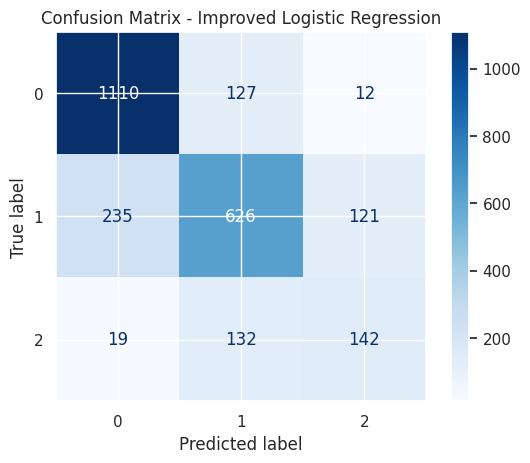


Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85      1249
         1.0       0.71      0.64      0.67       982
         2.0       0.52      0.48      0.50       293

    accuracy                           0.74      2524
   macro avg       0.68      0.67      0.67      2524
weighted avg       0.74      0.74      0.74      2524



In [5]:
# ======================
# Confusion Matrix + Report
# ======================
cm = confusion_matrix(y_val, best_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Improved Logistic Regression")
plt.show()

print("\nClassification Report:")
print(classification_report(y_val, best_preds))

In [6]:
# ======================
# TRAIN ON FULL DATA
# ======================
X_full_smote, y_full_smote = sm.fit_resample(X, y)
X_full_sel = selector.fit_transform(X_full_smote, y_full_smote)
X_test_sel = selector.transform(X_test)

logreg.fit(X_full_sel, y_full_smote)

# ======================
# Predict TEST using best threshold
# ======================
test_probs = logreg.predict_proba(X_test_sel)
test_preds = np.argmax((test_probs > best_t), axis=1)

# ======================
# Submission CSV
# ======================
submission = pd.DataFrame({
    IDCOL: test[IDCOL],
    TARGET: test_preds
})

save_path = "/kaggle/working/submission.csv"
submission.to_csv(save_path, index=False)

print("\n Submission saved:", save_path)
submission.head()


 Submission saved: /kaggle/working/submission.csv


,trip_id,spend_category
0,tour_id8gzpck76,1
1,tour_idow1zxkou,0
2,tour_idue7esfqz,0
3,tour_idnj3mjzpb,0
4,tour_ida3us5yk2,0
